# Notebook 2: Enhancing Images with Stable Diffusion Img2Img Pipeline


### 1. Install Required Libraries

In [1]:
# Run this cell to install necessary packages
!pip install --upgrade diffusers transformers torch torchvision ipywidgets
!pip install opencv-python matplotlib

#### 3.1 Optional: Install `accelerate` for faster and less memory-intense model loading.

In [2]:
!pip install accelerate

### 2. Import Libraries

In [3]:
import torch
from transformers import CLIPModel, CLIPProcessor
from diffusers import StableDiffusionImg2ImgPipeline, UniPCMultistepScheduler
from PIL import Image
import matplotlib.pyplot as plt

### 3. Load Models

In [4]:
# Use a seed for reproducibility
SEED = 0

In [5]:
# Load the Stable Diffusion img2img pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/jeremy/Documents/diffusion-playground/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
# Enable GPU acceleration
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe.to(device)

StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [7]:
# Use an efficient scheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

### 4. Prepare Input Image

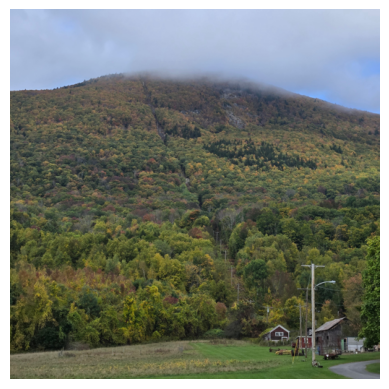

In [8]:
# Load the input image
input_image = Image.open("test-images/20240929_102048-EDIT.jpg").convert("RGB")
input_image = input_image.resize((512, 512))

plt.imshow(input_image)
plt.axis('off')  # Hide the axes
plt.show()

### 5. Define Parameters

In [9]:
# Set the denoising strength (lower value = closer to input, higher value = more artistic freedom)
denoising_strength = 0.5

# Set the number of sampling steps
num_inference_steps = 50

prompt = ""
negative_prompt = "low quality, blurry, deformed, bad anatomy"
guidance_scale = 7.5

### 6. Generate the Enhanced Image

In [10]:
# Generate the enhanced image
with torch.autocast(device):
    output = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        image=input_image,
        strength=denoising_strength,
        generator=torch.Generator(device="cpu").manual_seed(SEED),
    )

enhanced_image = output.images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

### 7. Display and Save the Results

In [11]:
# Save the enhanced image
enhanced_image.save("output-images/enhanced_img2img.jpg")

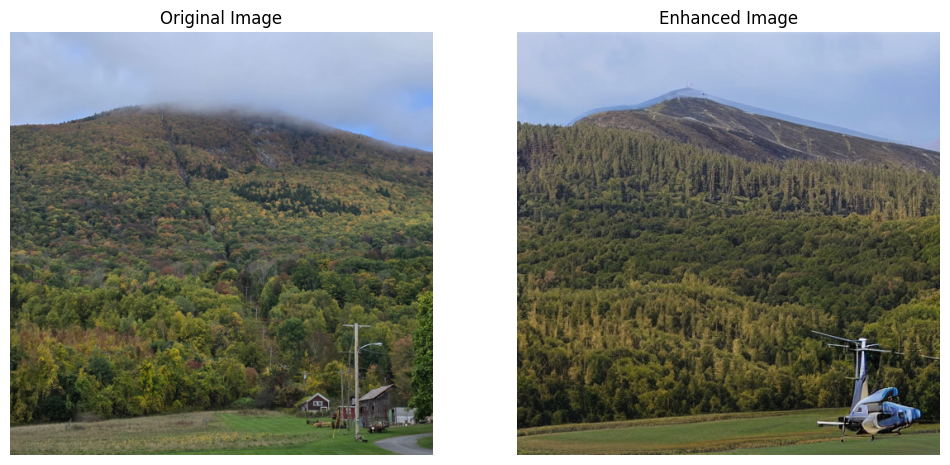

In [12]:
# Display the original and enhanced images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(enhanced_image)
ax[1].set_title("Enhanced Image")
ax[1].axis("off")

plt.show()

### 8. Style Transfer
By using a higher denoising strength in conjunction with a prompt, you can create a style transfer effect.

In [13]:
# Define the style transfer prompt
prompt = "A painting in the style of Vincent van Gogh"

# Set the denoising strength (controls the level of transformation)
denoising_strength = 0.8  # Higher value for more stylistic changes

In [14]:
# Generate the style-transferred image
with torch.autocast(device):
    output = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        image=input_image,
        strength=denoising_strength,
        generator=torch.Generator(device="cpu").manual_seed(SEED),
    )

styled_image = output.images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

### 9. Display and Save the Style-Transferred Image

In [15]:
# Save the style-transferred image
styled_image.save("output-images/styled_img2img.jpg")

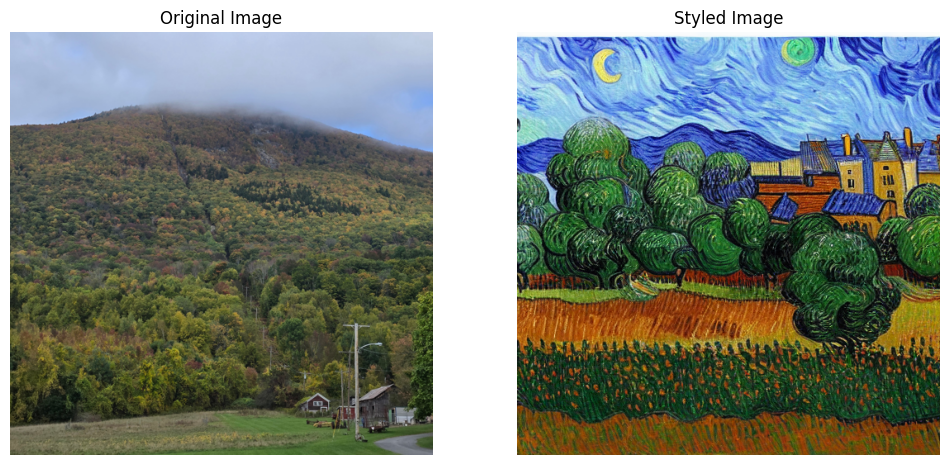

In [16]:
# Display the original and styled images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(styled_image)
ax[1].set_title("Styled Image")
ax[1].axis("off")

plt.show()

## Aesthetic scoring model for guiding the diffusion process

In [17]:
# Load the CLIP model for aesthetic scoring
clip_model = CLIPModel.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
clip_processor = CLIPProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
clip_model.to("cuda")

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 1024)
      (position_embedding): Embedding(77, 1024)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-23): 24 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,

In [18]:
def get_aesthetic_score(image):
    """
    Calculate the aesthetic score of an image using the CLIP model.
    """
    inputs = clip_processor(images=image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = clip_model.get_image_features(**inputs)
    # For simplicity, we'll treat the image features as the aesthetic score
    score = outputs.norm(dim=-1).item()
    return score

In [19]:
# Set the denoising strength (lower value = closer to input, higher value = more artistic freedom)
denoising_strength = 0.5

# Set the number of sampling steps (e.g., 50)
num_inference_steps = 50

# Define guidance scale and overall prompt
guidance_scale = 7.5
# prompt = "aesthetic pleasing landscape photo"
prompt = "balance harmony depth contrast symmetry proportion gradient texture light shadow intricate soft sharp refined elegant tranquil captivating detailed aesthetic sophisticated polished smooth vibrant subtle flowing inviting clarity minimal dynamic seamless coherence"

input_aes_scoree = get_aesthetic_score(input_image)
print(f"Initial Aesthetic Score: {input_aes_scoree}")

Initial Aesthetic Score: 20.688125610351562


In [20]:
with torch.autocast(device):
    output = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        image=input_image,
        strength=denoising_strength,
        generator=torch.Generator(device="cpu").manual_seed(SEED),
    )

aes_guided_image = output.images[0]
final_aes_score = get_aesthetic_score(aes_guided_image)
print(f"Final Aesthetic Score: {final_aes_score}")

  0%|          | 0/25 [00:00<?, ?it/s]

Final Aesthetic Score: 19.994043350219727


### Display and Save the Aesthetic-Guided Image

In [21]:
# Save the aesthetic-guided image
aes_guided_image.save("output-images/aes_guided_img2img.jpg")

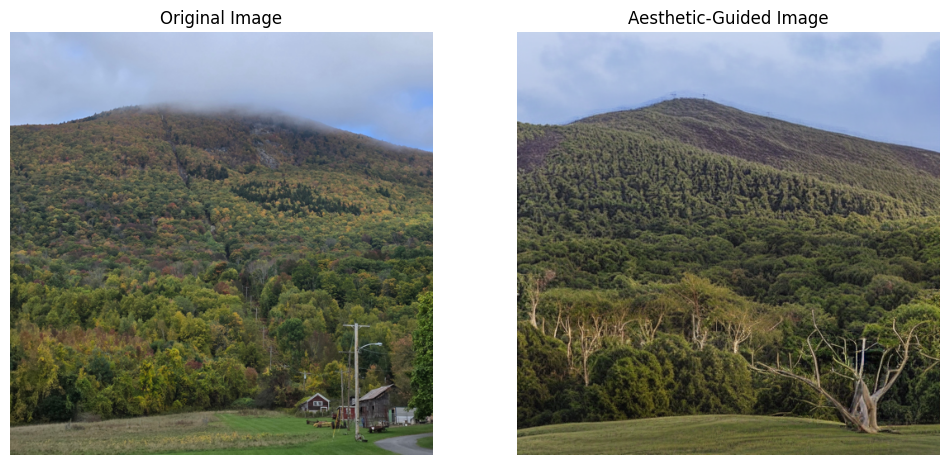

In [22]:
# Display the original and aesthetic-guided images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(input_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(aes_guided_image)
ax[1].set_title("Aesthetic-Guided Image")
ax[1].axis("off")

plt.show()